# Week 14 Problem 2

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says YOUR CODE HERE. Do not write your answer in anywhere else other than where it says YOUR CODE HERE. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select Kernel, and restart the kernel and run all cells (Restart & Run all).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select File → Save and CheckPoint)

5. When you are ready to submit your assignment, go to Dashboard → Assignments and click the Submit button. Your work is not submitted until you click Submit.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

7. If your code does not pass the unit tests, it will not pass the autograder.

**NOTE: Validation will take some time. Please be patient and start early.** 

## Author: Apurv Garg
### Primary Reviewer: Radhir Kothuri


# Due Date: 6 PM, April 30, 2018

In [2]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from nose.tools import assert_equal, assert_true, assert_is_instance
from numpy.testing import assert_array_almost_equal, assert_almost_equal

# These two lines suppress warnings that sometimes
# occur when making visualizations
import warnings
warnings.filterwarnings('ignore')

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 12})

# Set default Seaborn plotting style
sns.set_style('white')

# Dataset

The following dataset is created for the purpose of Hierarchical Modeling. We are creating 3 bins and 250 data points.

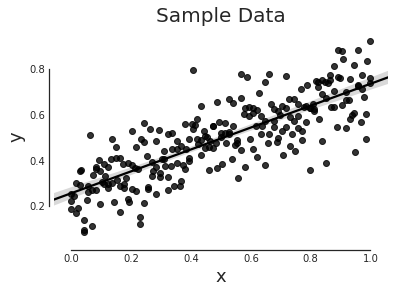

In [3]:
np.random.seed(40)
# A non-linear equation
def theModel(x, params = None):

    # Default values
    beta = 0.5
    alpha = 0.25

    if params:
        alpha = params['Intercept']
        beta = params['Slope']

    return (alpha + beta * x)

# Add random noise to model
def randomizeModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1
    
    x = np.linspace(xmin, xmax, num)   
    y = theModel(x) + sigma * np.random.randn(len(x))

    return(x, y)

# Generate model data in n_bins

n_bins = 3
n_pts = [100, 75, 75]

# Obtain sample data and plot data and model fit

x = [] ; y = [] ; b = []

for bin in range(n_bins):
    x_i, y_i = randomizeModel(num = n_pts[bin])
    b_i = [bin] * n_pts[bin]
    
    x.extend(x_i)
    y.extend(y_i)
    b.extend(b_i)

# Make a dataframe to hold the data and associated bin (categorical)
df = pd.DataFrame({'x': x, 'y': y, 'b': b})

# Plot entire data.
ax = sns.regplot(data = df, x = 'x', y = 'y', \
                 fit_reg=True, color='black', label="Data")
ax.set(title='Sample Data')
sns.despine(offset=5, trim=True)

# Problem 1

For this problem, complete the function `hierarchical1` which will take `bins` and `data` as parameters and return the generated sample points after computing the model likelihood. Following is expected from the function:

- stochastic variables `mui_i` and `sigmai_i` for the intercept value(where mui_i follows Normal`(mean=0, sd=1)` and sigmai_i follows [Weibull](https://en.wikipedia.org/wiki/Weibull_distribution)`(alpha=1, beta=2)`)
- stochastic variables `mus_i` and `sigmas_i` for the slope value(where mus_i follows Normal`(mean=0, sd=1)` and sigmas_i follows [Weibull](https://en.wikipedia.org/wiki/Weibull_distribution)`(alpha=1, beta=2)`)
- stochastic variable `Sigma` for observation errors (where sigma follows [Exponential]`(lambda=2)`)
- Use draws to be 100 and random_seed= 40 in pm.sample while generating sample points 
- `Intercept` is a normal distribution with parameters (mean=mui_i, sd=sigmai_i,shape=bins)
- `Slope` is a normal distribution with parameters (mean=mus_i, sd=sigmas_i,shape=bins)
- `Intercept`, `Slope` and `Sigma` are the names that should be used while defining distributions for intercept, slope and sigma respectively.
- Compute the hierarhical model likelihood and generate sample points. 

Refer to this [page](https://docs.pymc.io/api/distributions/continuous.html) for details about the distributions in pymc3.
Follow the methodology provided in the Class Notebook.

In [10]:
def hierarchical1(bins, data):
    '''           
    Parameters
    ----------
    bins : number of bins
    data : dataframe containing the data 
    
    Returns
    -------
    hierarchical_trace(the generated sample points after computing the model likelihood)
    '''

    # YOUR CODE HERE
    b_idx = data['b'].values
    with pm.Model() as hierarchical_model:
        mui_i = pm.Normal('mui_i', mu=0, sd=1)
        sigmai_i = pm.Weibull('sigmai_i', alpha=1, beta=2)

        mus_i = pm.Normal('mus_i', mu=0, sd=1)
        sigmas_i = pm.Weibull('sigmas_i', alpha=1,beta=2)

        intercept = pm.Normal('Intercept', mu = mui_i, sd = sigmai_i, shape=bins)
        slope = pm.Normal('Slope', mu = mus_i, sd = sigmas_i, shape=bins)

        sigma = pm.Exponential('Sigma', lam=2)

        y_exp =  intercept[b_idx] + slope[b_idx] * data.x

        likelihood = pm.Normal('yn', mu=y_exp, sd=sigma, observed=data.y)

        trace = pm.sample(draws=100, random_seed=40)
        return trace


In [11]:
trace1 = hierarchical1(3, df)
assert_is_instance(trace1, pm.backends.base.MultiTrace)
assert_true('Intercept' in trace1.varnames)
assert_true('Slope' in trace1.varnames)
assert_true('Sigma' in trace1.varnames)
assert_is_instance(trace1['Slope'], np.ndarray)
assert_is_instance(trace1['Intercept'], np.ndarray)
assert_almost_equal(trace1['Slope'][0][1], 0.57879831716520458, 3)
assert_almost_equal(trace1['Intercept'][0][1], 0.20868030655502456, 3)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Average Loss = -163.78:  10%|▉         | 19071/200000 [00:04<00:39, 4609.88it/s]
Convergence archived at 19400
Interrupted at 19,400 [9%]: Average Loss = 160.32
100%|██████████| 600/600 [00:06<00:00, 120.20it/s]


# Problem2

For this problem, complete the function `hierarchical2` which will take `bins` and `data` as parameters and return the generated sample points after computing the model likelihood.

- stochastic variables `mui_i` and `sigmai_i` for the intercept value(where mui_i follows [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution)`(mu=0, b=1)` and sigmai_i follows HalfCauchy`(beta=2)`)
- stochastic variables `mus_i` and `sigmas_i` for the slope value(where mus_i follows [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution)`(mu=0, b=1)` and sigmas_i follows HalfCauchy`(beta=2)`)
- stochastic variable `Sigma` for observation errors (where sigma follows Exponential`(lambda=5)`)
- Use draws to be 100 and random_seed= 40 in pm.sample while generating sample points
- `Intercept` is a normal distribution with parameters (mean=mui_i, sd=sigmai_i,shape=bins)
- `Slope` is a normal distribution with parameters (mean=mus_i, sd=sigmas_i,shape=bins)
- `Intercept`, `Slope` and `Sigma` are the names that should be used while defining distributions for intercept, slope and sigma respectively.
- Compute the hierarhical model likelihood and generate sample points. 

Refer to this [page](https://docs.pymc.io/api/distributions/continuous.html) for details about the distributions in pymc3.
Follow the methodology provided in the Class Notebook.

In [12]:
def hierarchical2(bins, data):
    '''           
    Parameters
    ----------
    bins : number of bins
    data : dataframe containing the data 
    
    Returns
    -------
    hierarchical_trace(the generated sample points after computing the model likelihood)
    '''

    # YOUR CODE HERE
    b_idx = data['b'].values
    with pm.Model() as hierarchical_model:
        mui_i = pm.Laplace('mui_i', mu=0, b=1)
        sigmai_i = pm.HalfCauchy('sigmai_i', beta=2)

        mus_i = pm.Laplace('mus_i', mu=0, b=1)
        sigmas_i = pm.HalfCauchy('sigmas_i', beta=2)

        intercept = pm.Normal('Intercept', mu = mui_i, sd = sigmai_i, shape=bins)
        slope = pm.Normal('Slope', mu = mus_i, sd = sigmas_i, shape=bins)

        sigma = pm.Exponential('Sigma', lam=5)

        y_exp =  intercept[b_idx] + slope[b_idx] * data.x

        likelihood = pm.Normal('yn', mu=y_exp, sd=sigma, observed=data.y)

        trace = pm.sample(draws=100, random_seed=40)
        return trace

In [13]:
trace2 = hierarchical2(3, df)
assert_is_instance(trace2, pm.backends.base.MultiTrace)
assert_true('Intercept' in trace2.varnames)
assert_true('Slope' in trace2.varnames)
assert_true('Sigma' in trace2.varnames)
assert_is_instance(trace2['Slope'], np.ndarray)
assert_is_instance(trace2['Intercept'], np.ndarray)
assert_almost_equal(trace2['Slope'][0][0], 0.45119101154406988, 3)
assert_almost_equal(trace2['Intercept'][0][0], 0.2583534782153169, 3)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -165.82:  10%|▉         | 19312/200000 [00:04<00:39, 4540.29it/s]
Convergence archived at 19400
Interrupted at 19,400 [9%]: Average Loss = 906.96
100%|██████████| 600/600 [00:05<00:00, 114.37it/s]
